# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [38]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import os

from torchvision import datasets , models
import torchvision.transforms as transforms

import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch

train_dt=os.path.join("/content/landmark_images","train")
test_dt=os.path.join("/content/landmark_images","test")

train_transform = transforms.Compose([transforms.Resize(256), 
                                             transforms.RandomHorizontalFlip(),
                                             transforms.RandomCrop(256),
                                             transforms.ToTensor()])


test_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.ToTensor()])
valid_size=0.2
batch_size=20
num_workers=0

train_data = datasets.ImageFolder(train_dt, transform=train_transform)
test_data = datasets.ImageFolder(test_dt, transform=test_transform)
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)
n_classes = len(train_data.classes)
classes = [class_.split(".")[1].replace("_", " ") for class_ in train_data.classes]

loaders_scratch= {'train': train_loader,'valid' : valid_loader, 'test' : test_loader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: images are resized via cropping , I augmented the dataset by rotating the images (to increase the rate of training and testing)

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

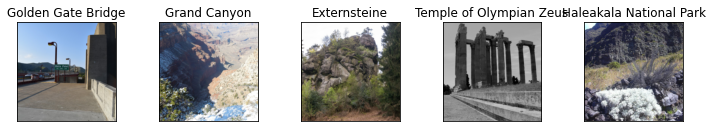

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

import matplotlib.pyplot as plt
%matplotlib inline
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])


### Initialize use_cuda variable

In [5]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [6]:
## TODO: select loss function
import torch.nn as nn
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    
    optimizer= torch.optim.Adam(model.parameters(), lr=0.001)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [7]:
#RuntimeError: [enforce fail 
#at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 32112640000 bytes.
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3,stride = 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3,stride = 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride = 1, padding=1)
        ## Maxpooling
        self.pool = nn.MaxPool2d(2, 2)
        
        ## Linear layer
        self.fc1 = nn.Linear(32*32*64 , 500)
        self.fc2 = nn.Linear(500 , 50)
        
        ## DropOut layer
        self.dropout = nn.Dropout(0.25)
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        ## Flatten immage
        x = x.view(-1,32*32*64)
        
        ## add DropOut
        x= self.dropout(x)
        
        # 1 st hidden layer 
        x= F.relu(self.fc1(x))
        
        # add dropout for hidden layer
        x= self.dropout(x)
        
        # 2 nd hidden layer
        x=self.fc2(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
torch.save(model_scratch, 'model_scratch.pt')
torch.load('model_scratch.pt')
model_scratch

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=50, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  conv1 => 3 input depths (because the input image consists of 3 layers in the form of RedGreenBlue), 16 layers (feature maps), 3 by 3 filter matrix and 1 by 1 padding value is adjusted to prevent overflows that may occur while navigating the filter matrix iamge.
conv2 => 16 input depth(the layer input is the feature map produced by the previous layer, so 16), 32 layers(feature map), 3 by 3 filter matrix and 1 by 1 padding value has been adjusted to prevent overflows that may occur while the filter matrix is navigating over the iamge.
conv3 =>32 input depth (the layer input is the feature map produced by the previous layer, so 32), 64 layers (feature map), 3 by 3 filter matrix and 1 by 1 padding value has been adjusted to prevent overflows that may occur while the filter matrix is navigating over the image.
pool => The generally preferred 2 by 2 pooling size has been chosen, it reduces the image size in half for each pooling. Therefore, while the input image size is 980 x 1024, 480 x 512 and the convolution output produces 64 layers, the iamge size that is the input to the neural network after the convolution and pooling layers becomes 512 * 480 * 64.
fc1 => As I mentioned above, the input image size and the middleware we set are output by setting the output size to 500.
fc2 => It finalizes the output from the previous layer to produce 50 results. (50 was chosen because there are 50 different classes)
flat= data is flattened for neural network
relu => The reli function is applied to produce a smooth result of the outputs produced as a result of the layers.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [8]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += ((1/ (batch_idx + 1))* (loss.data.item() - train_loss))
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 

            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
    
            # calculate average losses
            train_loss = train_loss/len(train_loader.sampler)
            valid_loss = valid_loss/len(valid_loader.sampler)
            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    valid_loss_min,
                    valid_loss))
            torch.save(model.state_dict(), save_path)
            torch.load(save_path)
            valid_loss_min = valid_loss
        
    model.load_state_dict(torch.load(save_path))
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [9]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname= m.__class__.__name__
    
    if classname.find('Conv2d') != -1:
        n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0)
        m.bias.data.fill_(0)
    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0)
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 0.000000 	Validation Loss: 0.079763
Validation loss decreased (inf --> 0.079763).  Saving model ...
Epoch: 2 	Training Loss: 0.000000 	Validation Loss: 7.826740
Epoch: 3 	Training Loss: 0.000000 	Validation Loss: 8.505529
Epoch: 4 	Training Loss: 0.000000 	Validation Loss: 11.491090
Epoch: 5 	Training Loss: 0.000000 	Validation Loss: 0.074573
Validation loss decreased (0.079763 --> 0.074573).  Saving model ...
Epoch: 6 	Training Loss: 0.000000 	Validation Loss: 0.074642
Epoch: 7 	Training Loss: 0.000000 	Validation Loss: 0.074468
Validation loss decreased (0.074573 --> 0.074468).  Saving model ...
Epoch: 8 	Training Loss: 0.000000 	Validation Loss: 0.074619
Epoch: 9 	Training Loss: 0.000000 	Validation Loss: 0.074510
Epoch: 10 	Training Loss: 0.000000 	Validation Loss: 0.074588
Epoch: 11 	Training Loss: 0.000000 	Validation Loss: 0.074723
Epoch: 12 	Training Loss: 0.000000 	Validation Loss: 0.074647
Epoch: 13 	Training Loss: 0.000000 	Validation Loss: 0.074775


### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [10]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 20

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 0.000000 	Validation Loss: 0.072240
Validation loss decreased (inf --> 0.072240).  Saving model ...
Epoch: 2 	Training Loss: 0.000000 	Validation Loss: 0.071567
Validation loss decreased (0.072240 --> 0.071567).  Saving model ...
Epoch: 3 	Training Loss: 0.000000 	Validation Loss: 0.068117
Validation loss decreased (0.071567 --> 0.068117).  Saving model ...
Epoch: 4 	Training Loss: 0.000000 	Validation Loss: 0.059976
Validation loss decreased (0.068117 --> 0.059976).  Saving model ...
Epoch: 5 	Training Loss: 0.000000 	Validation Loss: 0.066383
Epoch: 6 	Training Loss: 0.000000 	Validation Loss: 0.072927
Epoch: 7 	Training Loss: 0.000000 	Validation Loss: 0.057237
Validation loss decreased (0.059976 --> 0.057237).  Saving model ...
Epoch: 8 	Training Loss: 0.000000 	Validation Loss: 0.050750
Validation loss decreased (0.057237 --> 0.050750).  Saving model ...
Epoch: 9 	Training Loss: 0.000000 	Validation Loss: 0.063148
Epoch: 10 	Training Loss: 0.000000 	Valida

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [11]:

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
#model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.927213


Test Accuracy: 30% (377/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [39]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_data = datasets.ImageFolder(train_dt)
test_data = datasets.ImageFolder(test_dt)
batch_size = 32
num_workers=0
valid_size=.2

# obtain training indices that will be used for validation
len_train = len(train_data)
index = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * len_train))
train_idx, valid_idx = index[split:], index[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

train_transform = transforms.Compose([transforms.Resize(256), 
                                             transforms.RandomHorizontalFlip(),
                                             transforms.RandomCrop(256),
                                             transforms.ToTensor()])


transform = transforms.Compose([transforms.Resize(256),
                                    transforms.ToTensor()])




train_loader.dataset.transform=train_transform
valid_loader.dataset.transform=transform
test_loader.dataset.transform=transform

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}




### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [13]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer

    optimizer = torch.optim.SGD(model.parameters() , lr = 0.001)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [14]:
## TODO: Specify model architecture
"""
model_transfer = models.resnet50(pretrained=True)

model_transfer = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(256, len(train_data.classes))
)"""

model_transfer = models.vgg16(pretrained=True)
n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(train_data.classes))
model_transfer.classifier[6] = last_layer
model_transfer.classifier.dropout=0.25
print(n_inputs)
#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()
model_transfer
#torch.save(model_transfer, 'model_transfer.pt')
#torch.load('model_transfer.pt')
optimizer = get_optimizer_transfer(model_transfer)
print(model_transfer)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

4096
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  I think I will get better results by deepening the image by using the Vgg 16 model, besides, the model's large dataset and 1000 different class results beforehand caused me to choose this model.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [15]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
n_epochs=25
#train(n_epochs, loaders_transfer,model_transfer,optimizer, criterion_transfer,use_cuda, 'model_transfer.pt')

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion_transfer(output, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0


Epoch 1, Batch 20 loss: 3.9385926842689516
Epoch 1, Batch 40 loss: 3.8563727736473083
Epoch 1, Batch 60 loss: 3.7577171683311463
Epoch 1, Batch 80 loss: 3.6454480409622194
Epoch 1, Batch 100 loss: 3.4463539361953734
Epoch 1, Batch 120 loss: 3.3397944331169129
Epoch 2, Batch 20 loss: 2.9945907115936281
Epoch 2, Batch 40 loss: 2.6372930526733400
Epoch 2, Batch 60 loss: 2.6652779936790467
Epoch 2, Batch 80 loss: 2.4094363987445830
Epoch 2, Batch 100 loss: 2.2378608644008637
Epoch 2, Batch 120 loss: 2.1927577972412111
Epoch 3, Batch 20 loss: 1.8546891748905181
Epoch 3, Batch 40 loss: 1.9351888716220855
Epoch 3, Batch 60 loss: 1.7023985207080841
Epoch 3, Batch 80 loss: 1.8084379494190217
Epoch 3, Batch 100 loss: 1.7063041865825652
Epoch 3, Batch 120 loss: 1.7341756761074065
Epoch 4, Batch 20 loss: 1.5834302723407745
Epoch 4, Batch 40 loss: 1.4693437814712524
Epoch 4, Batch 60 loss: 1.4360472738742829
Epoch 4, Batch 80 loss: 1.4201254844665527
Epoch 4, Batch 100 loss: 1.3967639684677124
Epoc

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [16]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 3.314064


Test Accuracy: 65% (817/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [40]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    img = Image.open(img_path).convert('RGB')
    
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.ToTensor()])
    
    img = transform(img)
    img.unsqueeze_(0)
    
    if use_cuda:
        img = img.cuda()
        
    model_transfer.eval()
    output = model_transfer(img)
    top_values, top_idx = output.topk(k)

    top_classes = [classes[class_id] for class_id in top_idx[0].tolist()]
    return top_classes
# test on a sample image
predict_landmarks('/content/indir.jpg', 5)

['Brooklyn Bridge',
 'Forth Bridge',
 'Sydney Harbour Bridge',
 'Temple of Heaven',
 'Hanging Temple']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Is this is a picture of the

Brooklyn Bridge, Forth Bridge, Sydney Harbour Bridge ?


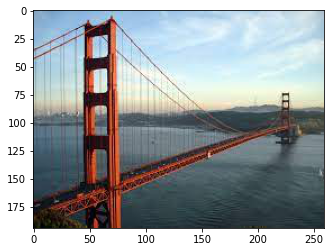

In [34]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img = Image.open(img_path).convert('RGB')
    image = transform(img)[:3,:,:].unsqueeze(0)
    plt.imshow(img)
    print("Is this is a picture of the\n")
    print(*predicted_landmarks, sep = ", ",end=" "),
    print("?")
    

# test on a sample image
import urllib.request
url="data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYVFRgWFhYYGBgaGhgaGBoaGhwZGBgYGRgZGhgYGBgcIy4lHB4rIRgYJjgmKy8xNTU1GiQ7QDs0Py40NTEBDAwMEA8QHhISHjQrJCE0NDQ0NDE0NDY0NDQ0NDE0NDQxNDQ0NDQ0NDQ0NDQ0NDQ0NjQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIAMIBAwMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAADAAECBAUGBwj/xABJEAABAwIDAwcJBQYEBAcAAAABAAIRAyEEEjFBUWEFIjJxgZGxBhNCUnKhssHwFCPC0eEHM2KCkqIkc7PxFTRT0hZDRIOEo8P/xAAZAQADAQEBAAAAAAAAAAAAAAAAAQIDBAX/xAA1EQACAQMCBQMCBQEJAQAAAAAAAQIDERIhMQQTQVFxYYHBMrEiMzSh4dEUIyRDRGKCkfAF/9oADAMBAAIRAxEAPwDcYISfSUw1SaF3pHC2AZTVhlNTaxEDVRIPIkGIhCxeWfKFlCk6o1jqgbYlvQDicoBfob25sxthJyUVdlRi5OyNprFIMXG+TnlnRLCyq5wcCSCA5+cEkwIEyN0aQjcqeXtFlmNc87TA5vYTrwlZc6Nr/t1Nnw01JpLbr0OoxNdrMmb03hjY3mT3WVjIvJ8FjnY/FOLy5rQxxYM05SHtuCAI16l6RyLWfkayoZdByP8AXa217dMRcbdd8ZwrqVRxfY1q8I40VUTvrZ/waEJsiMGpoXScYMMUwxSDSpMYgCVPSCh+bVymwblI0VF7FWKgpKfmDuVmnShWWMCTkNIzSwjYmDSNi1XU1DzSWQ8Sk6odoUmOV0UeCk6gFOSHiyuyjKRohEmFKmbpO49Ct9mnRT8zFoV5zY0VdyV2x2SINZwSqUZFlIOTl6GFysGIrKad5SDkmgTE4wqWIurT0CuISSG2UHMSTpK7E5FIIrGpmMQ3Yux823OQDcGGCN79DpoJK1lJIzUZS2LJaFSOKDiWsBeRqRZg11ft00ElHdhCRNVwcNS0c1g6x6X8xjgEGlic5+5bmEAZzzWCC7Ta7stbUJZf+6migvNv+iGJwQez74hzZbLeiyJGo9L+aRwCxvLWq12Cqc1xYDT5wAA/eMgMB12XiI36LeqYGSxz3F7g9pE2YPZZp2mTxWX+0Mf4Cr7VL/VYpndxfT7lQcVOPXX2PJTWc7mU2loMDK0EudwJ1d1WHBWKHIOJfDW4epJNpYWTbYXwN69L8j8M1j3WEw92l5LwZB6l09SkHuLXCRlHAgg2IOwjWdi5uHiqkMlodvFzdGpg9dPueU+THJ1TD4ssrMyP8yXZZa6xcyDLSRsPcvTMNQD8OBJFnEEatcC6HNO8Llccxw5UIcZP2UQdJGexI39VrTaYHacmt+4b1P8AicopJLiWvQdeTfCRfr8EsO4k5H9MCeD2+u35jYeBBNwUUPFUMzTBhwksdta4AweI3jaETDViZa6z2xmGy+jm72mD7xqF3Xa0PNaTV0SFNSbSRQOKlm4ouKxBtMhFBKiHqWVJghSEzhuUwxEDApuME0lFYVEvaE4r7ghq40yy0b0Cu8IbqxQyZSURuRFzkXDslDyK1RsnLYlbk3PhAqQpVXhBL1KRTYoUhAUQSeCcOATYh2sT5ALkqBrk6BQLHFK3cdxPqKlUdKvMwpOqk/CDci6QWbMeElp/Y27z3JIzQYM5tmFLsxrPzAHo9GmBANx6WvpEqX27O1zaLMwAIznm0xb0Tq7+URxSoYEOJNV3nCCLEQwGG6M07TJV6bP7fgCaT8fcpyj5/ZA2YAEzUd5x2wEQxp/hZp2mTxVjDMH9rfFyKAFHDt+Fvi5NJIhyctxsSzo+0Pmuc/aKz/AVfapf6rF01f0faHzXM/tQrluBiBDqtMOHrNBL44Xa1Kb0Y6aWcfI3kq2ah/y3fG1dO2lz/wCUeJXivJflliKDi5rabiQRzw4xmLXWhw0iArtX9oeOdJDqbDEc1my/rl11z8PenTs9zu41c6rlHayOk5eIZyoSTAGFZJ2AmoYBO/RdbyXUIpta4QC12R2wy5/NO51j194Xk3I+LfWdXqVHl73CkXOMSSKjANABoAOxevcj0c1BwNxzhB9pyyjL/EN+htVjbg0n0ZeqNOU9R8EHF0iRLTle2cro03gja0xcdR1AUi5zJa+7YhjzxFmv47jt011tVG2M7iu7JM8rFxd0V6FbNIIyuFnN3HgdoOwowaoYnDzDmHK8Gx2EbWO/hPu1U6D843EWc06tO4/ntTUugnHqiQMKQqcE4YpQi6FqRLyeCaFOEwai4yOVKFItSyIuBBJxU8iWRO5JBpUw+E4YpCkpbQ1cFcqTWowYiAKXIpIqlhSFFWkziAlkx2RBjAEUtG5Qa9PcqHcasOCk94hCLoQ3vRYdxecSQ8ySAuZFJt3df4Wp3Cz+34AiUxd3X+FqYts/t+ELTIzsFATYY/C3xciBqhh2fCPFyHIEh8Q/o+01ct+09mbBtA1NamB25h811tdth7TVzf7SR/hWf59H4is5y0ZrSjea8o8q5G8mq+JeWMDQQS0lzsrQWjnXgzC6yj+y2qTldiabTE81j3jdtLVreQrIqNPrOqk9fOBnfovQA3n/AMv4lhRnmm33sd/FxdGSjHqrnjDeRzhK+Jw7nh5Y2jDgModnexw5smDzoiTovXPJ0DzLut/iV535UtjlOt/8M/3UQvQ/J5p807rcsl+e/H9DWbb4RN918mvUotcHAgEFtwbg2OqrGkWBwcczLw46s3Nedrf4u/erIdrr0R81JzuY7qd4Lp16HnJrqJ+H06wq2JwZLg9tnhpF+i4SDldw3HUTxILhxpNbAJp80RElmmg2t4ajZawutrAkEXBBII0ItdGUgxitUUqDw8GLEHK5p1a6Acp7wdxBBCLkUq9K5eyA8b7B4AByu+R1HVIJKLw4TcEWc06tO0H6uIIsqVTuTKn1QHIlCskBRLFakZuIGEsqLlTZUZCsQDeCfzamAnEochoH5tNCJlTZUZCsQTZSihilMaBJyHYDBSDN9kQuKG4FK4CDgNig+ruTliiWJ6CuwT0JwVgsTFidxWKqSNkSSyHYoUxd3X+FqUWf9eiE7G3d1/halHT+vRWeZpiWGwo4cj3DxcpNCjQF+w/E5JzGoksTGUe03xXMftM/5MR/16Mz7RXT4lvN7W+K4v8Aa5VczDUS0x9+0xsJax7hI2iRKTlfQumrST9St5DVHefpt5sTXJuZ1qfNejaP/l/EvnDAct4ii/PTqOa6c02N3CHWIi8laz/LnlB0n7S4HSzKYsZ25Pes6dNwTXqdvFS50k49FbX0Ok8sARylWdmtGEJ3N+8oj9V6H5KvmgTmzAlxBiLQF4hgMS+ozEve4ue52HLnOMlx89qSvYvIh80NfRZ8DVk3/eft+yNZRtwqXaz+51QOvsj5pQMruo+CG12t/RHzSA5juo+C1y9Tz7PsSeBlb1s8QhGmWPJYJaRJZbUm7m7ibW0PAkkkqDmt62fEE88/+X5p5eorNdB6dVr2uc24M/CJBGoPBRxFIkhzTDwCP4XD1X8NYOonrBrvYYLmGHHX1XAMFncba6jiLI9OvmMXDhOZp1GneOIslkgs90ToVg8HUEGHNOrSPqx0KPCp1WTDmnK8EgHWRmPNcNrfoKVDEZpBGVzek35g7Wnf4GQqzE4lqEoQ8yWdGYsQkJQh50s6WTDEJCUIfnUvOpZseISEoQnVo8E/nUZsWKJwllQ/OLK8oa9XzYbReKby+mA8tDw1pe0Olp1kE2Rmx4I2MqYtCwORjiGVqjK9fz33dNzD5ttPLzqgcMrZnQX4LaNVGbBxRItUHBMaig56MycRQkh5kk8wxMNmKueseATjFDnfWxcy3lFonnXtp1aKVPlNnOk6tt17J7ingzW6OpbihAUaOLE/1fEVyh5bAgAEjQns3KNPlghzSYynNYSXjnGxmBP5o5bDKJ1+JxnN7W+IXH/tUeX4ai0anENA6zTqAeKJieWQW5QQCYgmcoM3zW0Cx/LDlFtQUWt0GJYRJvEPA8UsXHXsXDGUku7OI5O5Iq1nljGy4ENMmACbRPWD3LpW/s9xOmegDGaM79mycmt1Y8m/u31nbqhd3Ofb3e9dOOW25gYceaQRxkRrqppzc726HTxEFSsl1TPP8Jg30ftNJ4Aex1AOgyP3rSCDtBBB7V6j5HV8tBvFjD/Y1eeY2vnxGMfET9mPcaY+S6XkvlQUaNKQTmps2/wNWTTdW3r8G0mv7Lf0X3O9Zi/hb80m4zmnq/CFwx8qI9C8AdLr3BC/8UviMg43O4Dct+UzzsonfuxfNb1s+IKX2vnj2T4hcI3yoBABYZluhnQgox8pWZgb6HW20JcphlE7QYvmm+38KarXDiLkEEQRqOjPZw0XEnykEWG31uCjU8pIdYgier1UcpjzR3DMfFna5oB9F1/cb6d0qdWqHbYIcII1HRns4bV57iPKWWwDEkE2naDtVB/lA4mC98TrMbokA8E+Swzj0PU6XKHougOvG50bW/ls46o32oLx9/LrwdXRqOcb8QdEU+VVciGuvx9LtEX4Jcl9xZp6W1PW/tQTnFtGvivGX+UuJPpkHt8CUGpy3Wd0nk9YB+SrkvuLmrsewVuXaLDBeJ4c6OuNEFvlHQPp97XD5LyJnK7xuPWB8kQ8suPoN9/5quSiOYeoVfKmjaC8wfV3daFiPK+mOgx7z2NHeZPuXmbeVztY09pCIeXHbGN7SU+VEWZ6GfLFv/Sf/UNFn+UPLWHr0Q15e1hqUs8gthrXgkZmm2huN64Z/KrzoGjqB+ZVTE4xzgM5kSDECLdm9S6cVsXGTbPQ/JuvhaeIqeYeC006OY5y4F+aqDDnHcWGF1n21nrDvXiGGxLgSWGJyzlAGk7AEb/idT1vBTy79SpSs9j2J/K1Iavb3j5ILuXaA9Mdx99rLyhvKz4iR1wJTDlV++ewJ8pdyMj1j/jFI/8AmN74SXlf/Fneq3uP5pKeUu48vQOyqADLX7NNu6QISGIBPQf3I7de75p26ns+a7cTDIE18Dov7kP7UfUedfFXGaDqCdmv9XiErBfcpVahynmO7dmnBUOV6pPm5Zliqy88TZb1bolZnlL0Kd7+dZA36qJr8LNaL/HHyS5NMHE2mHG2/nVLJn1XE6R2KtybimCrUl8c+delzn9+o71vDEskHONDt6ly8KrZXPQ/+i7uLXY5pnTxXs0T/cxa7iPNYcRM0mbT6jNyzcSCa+KIJhzKUGNTLBAPWCFvclGKNIkn923s5rdFP+o9/gt/o/Zfcxyw7AfHvTZTtB7Le/aukZU0vsCdlW3Z+ELtPJOcFMHeLiJLf0TPYe32gfBdL9p5o09HYd4Uziriw0OzqQByWUxptUcjjs+u1daMSLywa7goEsOrG6jYNw4IA5M0XnYSoGg/1T3Lq34ekfRGo0JG3cFB+FpbG7RoTuHFAXOWYx26RuOn6dak6hOltsE9litt2CBM5W8DnIPdkUH8kOOjwPftSt2Ky7mG8xZ4PX6Q/MIbgRcXG8fPctl/IzwAMwdvm41Ita3YqL+THtNgW8QZ374OxLVD/CyhmT9quP5OftA6xIPaIjwVd+CcDGcdsz7pRkuosG9gQlSEbSFOlgy7Qz4dsKbMOz0jmduBn4bDvCh1Io1VCT1sNTqWPOgaHjwBTP50TcSLRsVhzCBLWExpAzR2M07XKrX5Qd6AhsmJMQP5YPvKV5PZFKMYvVr2DsokEgW6Jvzd4KIcNaTETEiCJN9Vn0K7nZi4yYMHRbOCY19FzS45oDmgbXAG3vSd4q4pYydkDZTaDr7t/WmfTAvY7xA0O1BdhKugY49V/enGFq7WPHZKdm9TPRaDZW70lcbya71h/S7/ALUk8WK6Dh5nXYPmk15nXd81XD7pxVuuo5y0x1hdOw313+IVVlaycVb9/wAlI+5bq9E32LF8rv3bL+n+By0H1OaepZHlO+abPb/A5KWzLp/Ujmm7Or5lTAsexXMByU6pV80DEBxLomA1xExI2wNdq0j5OHQVRfezd/MudNN2R3STgk5aXuLybPNqe3hv9VdXyY77ij7DfhC5jkKiWGqx0S2phQY0/fDThddLycf8PR9lvwrm/wA5efg7W78K/HyWGO000CdrrfW4ITHi3UFJjrdnyC7zxSZdYfy+ISa8F20Rv0MxoozzR2eITk3Hb8kAEb17Uw+Y8Aotd4pNcI+twSAkfmPEJz+IeAQa1ZrdXAXGv5LPxPLdMSGy862003oyRSg2agi1tyYvaBJgC2th0lzj+WKr+g0N6hfgg/Zaj87nudlYG5i4EgZzzBYGDIUOoo7msaEpbfwblblWk0GHZiJkNvt/UKi7ld77U2dRPO1nTZtNuCp4SlmtTpufxfDWjeCBaQY271qU+SHuH3r7eoyw7TAnQHSxm6jmSl9KNeTCH1MzquIc4w+prbIznGbE9ECCrGF5NeeiwMBiXVLu7GDTt+S28NhWM6DQ07xd39RvtR8yapyf1MmVeMfoXuzPpckM9NznnceazsY381cbQYBAaANwEDuCKHpsy0UYrZGEqspbsh5pgBt+q5fluowhpFB7DmBJczKHCDzZaV1ZeOCyOWqrS0C2qZCOaY9rs3Myk5coAcd8m/Yuk5EwAAzEXPAhZ2EpAuk2XSYYAD9UrFNh8qRJ4JwRx7ylPX3pkkMx3BJPm6+9JAHKhyfMq/nE4qLQzLDXJwfrsVcP4FPn+uxA1uyw/Q3Wby8Pu2e2PhcrhcVncrn7se03wKmWzLp/UvJp+T1P72obdE7PWqvOuzQKzFx2oXIgGZ5i5afc9xHinLTPaVw8O71Jex6nHxtTh7lXBn72v7WFP/2sK2KZjD0r7Gj3H8li4S1XEf8AsHuexa//AKdnA+GcKJ/nrz8G0P0b8fJFlXS6dtW31uVN7wP97zuhU6nKTG2AJNtBPZqu/JHjqDepsitYdninfiwDJIGq5yrj3nQZRv3pMwr3kSHQYJ6rZiG7dqhztvp5NYUctFd+DYqcuNbIBJMzw3qi/lao6A207rndZMMMxlnOD5MQ0AmW6AuHRGs3HR0MI7XudIpMgEkB0SQLHM4nmi5IiDwKydW/0q/2OmPC2+ppeNWVvsT3kl7rXhzjE67DF4kxYpNZSbGrzcjYAdlok3i0aK63k4uvUeS4WGUycskgF5HbbeVbp4cN6DQ3qHzN+zRCjOe+iCVSjT2V2VGUKzoHNpN0IFjGpI9KdmoBHWtDkxgpsqU3Br21DTJLrmWTBy6bRv6O1Qy8UvNlaRopbnNPipy20NEVwnFYbFmFp3pspWtjnbb3NU10vPj6KyoO9SDnb4QI1BVHBO54WO+q7/a6rVMW4b/ekM2MRXGxZOJ5xVfzrjt7E4cdoQMvYNkLWasTDViCrbcUQgLmmYSss0407giMxWYgAXJA12kwgRbyjgkqb8e1pggyNbFMgZgABTa8IISlaEWDh6QqePyQmvm0J5ASGlqwwqD6lUeVnnzQHFvy/MIuIxLW7TNu6d+5YeKxBe7UxaBJgQBNtNihu+xpGLjZs6jkeoA5xPqOPcWn5pVsU0XzSL6GVzuHxz2kQQJ5ptsOUfIKPmXnSXSN1p1jriO9ctODhJtvc9GvVVaMVFN4mzyfXD313DQsp/2vYFf5XqluFYQYOdwtr0nrneR8SG5ydrYtpIc0+AK2auKDmNbna0Nc55ghzruJHAEZ1jUT5ql6nTRadDHZtMz2YZ7oIJJBEExA1B17FcODAk1XgFxBiBm4QAJAM7BCVPEuqECnIDWjM0A5vRObNEwRa2hUm0CRNR8Oi2Q5nCQJzHQEbCCfctMpy028bmLp0YK719XsS+0MYQGguAIgmSCC4DmjUXgajqTsoVHiHHmOBnNDRlmwLGi54xbKL6FFpkNAyNyjWek7vPR7ISz3m871pGj1f8mFTjFbGH9EFZhWCT05tD+jBEGGC08Z2mysF+zTcBoOzYqvnCol56+tbxhGOxxzrSlu/Yukbo8Es3GfreqorJvOlUZFvOUxqQq/nUi4naEAWRUHV4JCqNmqrSfq6gaiALrqg2hBNWNEEvm096DUMb0gLD6k/ogOf9FVy5EYZQMI1g3fXYpocxqO5PmQAVqsNed/iFUYAeCOxzhucPegQYun9RPvUc+U5oBgzuUHPBTZxCAJYmuXvc/K7nEkwbSbmO2UkKeBTqSsjIzqBxTRt7VQdVcW5i9g3NFye6w7Y0VYSeJVZMvBJ9zTqY4Rab6EcNbKpUxTzthWsNTcGFpYy56b5kSI5otB6+CMzk1rBmfJAOplt90XdPYsnUit9TpjQqS2VkZjBLgCTcjWbX1hbFTkdgADXkk9IlsACJ5rRJOuoQTiGtHNZlbc3GWwcQRlBmTEa7RZRqE1XZWn1gWjMBcOGYD0okTYm22VnKUm7rRI3p0qSjZ6t7F3B4drQS2HmC2JbmIMZrSBE5RJdOoQm8oRMtAaAQAbmckuNrWkDQ67VVoAecE1G0zJDRYkAAjnAc0E3kE6koWKxxcXGk0BrLB5GZxFxIzaWJO8Das1ByeuprKrGEFbT0DUaciqTeaTnA7TDmQ49hcLWsdkLbpUi2lmgQ11VpGlzVtp1ELI5Orl1N7jMmlWBuSZAZEkrdrO+4d/m1P9Zyid8kvVGsLctv8A2tlXzsjLYNtDQIHC21CeeKE14H1/upCovQSUdEeFKUpO7dwjHFPmQXPTNcmSGL9iQneUMP8Aqyk0pATzcVIOVdz0s31dMCyXpNdxCCH/AFdRe76/QJAWc8a+7RQe9Vs7uJH9ISLh1dnz0QFgtR+6R3eCgKu9DL9xntn3CVEv3/JAyw106GOtSy7x3KuFMPIQBYa+NqYuG5V8+9Nm3FAFyk4Ijnj6kLP84doRC/6KALbanX3ymdWG5UnP4p21N5QBZ8+NxSVXMNySAMEMg3H666fW1TfVAjKS0zaNxG3amqvDgXeqLHhohtDTzjoZ01BgaBc7berOm6Wxep4tx0cQdJ2jcAdf9lOjmOYNLQBHSAgg5s0zGsyesBZ1KmbAmMwtOki6s4atzZkE3gHaGi8cbpWS2NFUfcuuZTgDnEjUAkN1JgEjMRzjsB0vZDxlUljhYCNG2B69p7VJj2v0sYkiR2xOtkLF0iGuFjIMRt6oWkMduvqZ1Jzb10XoY1XZaLDt2T7loMrVWCMluH6W9yhyNQD67Q4ZmyZB0gNJA9ysYl/mKj2GS0dE7SNgPhPBNSWWPoW6bdNz6N2J8j1JNVsZR5usQNxLQCPcF0Nf/l3/AOY499Sfmuc5IcTUcXenSqx1ZLeC6Gof8O/2/wATT81y1dKsfKO6g78NLwzLlTDkDMnDl3nihyer3JNePqEEPP0JSLuvuCALGZKUAP6/epB/A96QBc5+p/NMYP0EJx6lGeo+KYrBSSP1T5t8/XUCq5qdnW2R3qDnj+H+5vgkOwfPH0PHKCkXb/z990AP4nsfPilm3/XcgdgzX/Un81Iu+rILfq6U8UDJucnbU3qE8frvThAiZdKSYdaR+tfyQA4fCcOUM43+P5piAdvwoAKbqBJGz3oZJH0PzSz/AFZAh83D3pKGYJIGZNP927sVcaJJLJdfJbLzv3fYfhCFQ1HV+SSSjoyjRH7xvV+avYfpDgGRw1SSWL+DQzeSbYkAaZnfC9R8o/37uzwCSS1j+b7G8v0v/L4Dcl9Nn+VU+By3Xf8AL1PaH/5pkllW/NXsdHDfp5eH9jHaouTpLuPHENAiN+SSSYgbk2xOkgaJt0USkkkALOZ1KMEkkDAvHik1JJABknaHr+RSSUMfUCXHzgv6I8Udv/b4PSSWTLQqam9JJbmZByHtTpJgSYoVEkkAMUkkkCP/2Q=="

urllib.request.urlretrieve(url, "indir.jpg")
suggest_locations('indir.jpg')

Is this is a picture of the

Eiffel Tower, Temple of Heaven, Vienna City Hall ?


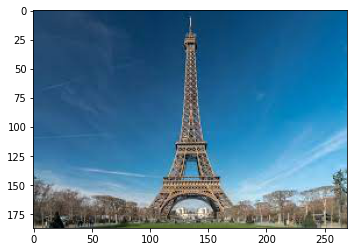

In [35]:
import urllib.request

url="data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBESEhISEhIRERgREhEREhESERISERERGBgZGRgUGBgcIS4lHB4rHxgYJkYmKy80NTU1GiU7QDszPy40NTEBDAwMEA8QHhISHjQrJCs0NDQ0NDQ0NDQ0NDQ2NDU0NDQ0NDQxNDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIALsBDgMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAABAgADBAUGB//EADsQAAICAQIEBAQEBQMDBQEAAAECABEDEiEEIjFBBRNRcTJhgZEUUqGxBiNCwdGC4fAzcvFDYmOSwhX/xAAaAQADAQEBAQAAAAAAAAAAAAAAAQIDBQQG/8QAKREAAgICAQIGAgIDAAAAAAAAAAECEQMSMSFRBBMjQWGBFCKhsQUkM//aAAwDAQACEQMRAD8A8TDCRFnQPCOIREuMDEMY1KnURiYesAM7LFAmvQDEfD3EdiaMpEWpaUMQrGQxZKhqSACkSARqkAlCJCBCBCBAQ2DCzuqKLLkKoomyeg2gImvwlgvEYGOwXNjdj6KrBifsDMpEm+tDr9bFhqGoalkAAhAhqQCNCZAIwEgEcCUSACMBCBCBARAIwEIEcCMQAIQJKjAShNkqSSSo0jOUgQ1IBDUtIybM2mBkjSTwnWK9JgqORJABKkj0JCsAArSxHlQSMIBYHqVlZY4ldRiZSy1FEtdYhECGCpAIahqUBAIahAhAgI2+F4VLh2dV0kmiQLAUk9fp+sr4zhRjoh1ay2ykGqJ7jY/SdHw/inXEExYVytr0vqyslFtRGw7UE3s3fat8ni2bIz4xkxjExxa1UZDkGnWd7PuJ5I5ZPNXtweuWKKw378nPAhAjVCBPajwsFQgRqhAjQmACMBJUYCMkgEYCECNUpIlsiiGFBGqMVigRqhqGo0iWxakjGACWkZSYAI0IEdVvpKIbMFySESTwHXJFMMhgAtw3ARJAAxwLiQqYADJ2ldyzLEowE2VtBUt0nvBpEoRWBIBGqECAiCNUgEcCAjrfw+FCudIs5MCszFtOjnq6OwG9keomTxdtb43atWgpQvlAcmtz3BUj1BB2ups8GIVQbq86VyhiNAHMAepGs8vez6XMnHm8ePf+vN0HKPgO3uSSR2JI2qh44pfkHsk3+OYAIwEgEZRPfRzyaZAI9QhYxMUCOBCBGAjSJYtRgJKjqJRLCBCBGqECNIlsWpKhhIlpGcpCVDUMNSkjNsAEsxtUUCOFjoi6OcYKhhnPOzZXUkepCh/8wASoCJYKkMAEUQlZAJZUBFbHaISY5EWpQMElQgQ6YAKBJpjVCFgSxQIajBYwWOhHU8LbTjTmK3nY8vx7KlFN/iG/0vp1Gbi6ONTZNZH3ql5gPs/LuPbp0mzgbGPGdRSsjMzAG8dlAGX1JK19PYjLmN4zbE/zEYfldSr/AMzrsWrp8u08Mf8Av9nukv8AX+jngRwIwWELOic0gENRgsOmNIlsUCNUYLDUpIlsSOqyARlEpIzcg1JUapJSRDYtSGMZKlJGcpC1CBCBCBGQ2ACWotxQJYNoyGzl1BY9L945EBWeA7hNZ9vbaED1794lS1SDACt0qKqy4pAUqAFTJGuOIGWAFZWKVlok0wEVASBZZUIEdCsULGCwgQgR0KwBYQscCOFjJs38Oh0YNKqTzFGOghW1sG13vVUPTffaZaJx5l5VK5Ed05fj3W1r+mn7+o67VqqlxbbKoOQWLb+YWWgRvVj2q6MycMvJl6kBR5Y1AlF1oSGAGxP19ROan632dOS9D6MoWMFjVGVZ1UchsAWMFhqECNEti1GVYahAjSM3IXyzGVZcX2oQASkQ2isiQCMRBUtIylIWoQI1QgSqM2wVCBGAhCxktgAjCNpjJjuBN2cspAVl5gqc+jvWZysFS/TFKR0BWGMtDA9YhWRYUFhZe43hFGQbQ1CgsU44NMtEFR0S2VaYVEs0yaYybFqDTLAIQsYWKojKIQsdYUTZ0kVteIKFLBcJQkqQoIVqIPcksL+/yoRDr4lKCmsnmfDTgc4qjsbUfbb56nCq4tuRCAooMRkxp23td0uu4HrKUQHK+7MrMRVUUfIh29iX6dPrOSn6l/Z12vSr6/g5umECWKIdM7KRw2yuoajaY4WUkQ5CVIBHAhAlJGTYqiMw7RkEhWMlvoVkSVHKwjGZSMW2xAIQsuXHLVxx2JRbKFSWaJeMcYJFZWpmGOXY8ddRLRjlqpByBQ6nm4wMbT8x+sBT5/vPIdeyVBUZR8/0jAD5/aKgsrKxCs0UPn+kFD0P3jCypfnDolhQen6xkr0gKympKlzKItQoTYgk0xqjLHRNlemOolgWMEjoVlYWWYsWplX8zBfuajAS/hK8xb2Atia6aQW/tFJ6xbHBbSS7lmVyTnyaSToy+YuiyqMCpKGt+tdNia3lWN2GTFkClSceNsdoFDqtKNW2x5e/22l/F4tOLrodgBp/l6XYlW5tLGyQrdQLBrcm5kshMd0zFX1opsIVNkqTvtqHtdG9pxotNncdoXLi0MyfkZl+xr+0Wpp4mtZKmwwVgfXUoJP3JlU7mN7RT7nzuVaza7NiaYQI8NTSjFyK9MKrLAksVIyeRAkBWXaYRjghMpVJeix0xy5McGwjErVJoTDLseH1jtIcjaMK5MhSEJNOiMmEsYbC1Mypc14eEJm7BwgXr9pqAPYVIc+xtHD7s+eaJNE0aZNEk2sz6YpWaSkUpALKRHAjaJNMKFsJphCRwI2mArK1WApLgsbTGJsz6YQkuKQaYyWxVWMBCBHCwFsVlZWvEODkUNixqiq2t8D5S+vWGUkHYAL6VVk9JpCy/wAzyxjQ40bzNeTVkrSNGyr79TfTm7TzeLdYz1eC65fo5+YGhq4nhwF2FcGw5UCnVX5QGHN05gLgRSAWHE4fiq/wY6spOsX1WkNt/wDGb6bU8Z40Q2LH+HxDlbKQ6kMpLsuoL22QHr3lnD+MqVyAYsbM2Pzii42tmRktvipiBfvXUTlayq6OvtG6sOV8wyY0ORciMuUkjAuKtBQDp1vUDfvNIWXcPxDZbUrjooMwfGCCGoBlayb21b9OQbmP5c63gpenXycX/IQfm38GcJHCS7RHXHPZZ4NSpUjBJaMccJCwopCSxElq45aqRNjUSoY5fixy3FguaBjkuRrGHuUESBfSahiliYvQfWTsVq2ZsfDd2/3nQwYtuUV8+8K41UWxsxH4k9F2ktuRaUY8l5VV37/OZcmW+/2lZBPUkyaIKNClNvg822ERfLnTRVcWCDuQfUEdQfQ/KP8Ahh+UTPc30OQ2OIcVzpvwpEqfER2lqRLiznnCfSTyj6H7TZp9xLUYjv8A3j2J1RzvL+UGmdXzX/8AafdVMQ79UU+20LBxXc5umELOiqY+6N9H/wAiN5OI/nH0Uj94bEuL7nNKyaJvbhU7P91Mn4X0dD/qr95SkiHGRh0Rgk1DB7fQiMcJ9P2j2J1ZnTGWIA6kgD3Ms48bPTgkbYwWrSoCgXXVdgfv8rfDnxiz5idNIp1Jttr69Kvf1qY+IfEdCWNCU6qrIQ+jm0dehKhd+/Sc3xeRSdJ8HV8DicU5NcmUcHrd/MbzNCpjBBIooND9PVkuMeEXHkwupKAucbHUTy5EZO/TmZd5s4PQF5nQHYteRLugGJ3/ADX94niqq2F9LIWWnUF0oshDAbn1AmqjHyKtXRjKU/yLp1Zn4VnQ4w40vjfRkKlCGXcsoW9lPOLA+lTrtjHYgjsRuCOxH0nLyPj1ZCj4yj2+RGfHSOwsg83TV17m/Sb8XHYERNeTGmkFebIgBA3BG/QA19O/WYeFyKMqfDPR4zC5xtcr+iwY5aqS7GoYArRBFgjoR6y1cc6exyNKMwxQjHNYxyxcMNh6GRccvx4LmtMH/iXDGBJcio4+5SmLaPoqXeWfb94wUD5mTsa6laJ6/cwPkr4R9ZZpLdYdFQsH8GXyy3WOMdTQqwlY9iNShEuMcIHcTl+LeKHGrrjOl1IXmU6bI1E2aFVXqbI2icHjycRhTn8opSm99gq1uTuTd/4mbyq6XU0WLpbOHh4shiqaF08xGkKxvb06/wC07KZQAmoMC90NiTQsmh2rvOBwzs2fISpYDIRq3IsDmYs1e1S/gMqs5e30YywRTe9fL69J4lkaOk8UWekTCxWypF9j1+0oycMfSUP48VJGnVpGkE2CT+aqmfL46TYtlIr4QDdnpR7V+0tZqIeCzU2H5RThHylnDeKnIyoMfUkEjqANra+nedY8LjauxIuposyZlLA0cQYBHGFfX+86eThsa9XQe7ASkri/Pj37h1MrzV3J8l9jIeDB6EfXaVPwjLOpjxAi1YMPkQw/SN5B7f7RrIS8XwccIe4h8oH5Tptw3rA3C+36y1kRm8TOYcMhxek6Q4U/8MweKcSMK/C7k7FcYBYA/Kx+kmeZKLY8eBymkcdfC0JonhkD6Dk0O69y7XTDYHb/AFekC+H15ZY8MtLjIF5CF3Lsdm3oir736S7huKwuzKMbAqusnRRIUkgbN3Ymh62RMmXIFN5/w2EEciMz5H0rbAAAiwGCsKG19iLnH2ldHb1VG9HyAD+bw62EJ5cjaWYlnvn3oV736RmOQijl4UagoIKZCLZjqBp+yj63t0nLfxTgOgCtq1G70qdThq5mHcqxHcgnrvCPF+AbUCqDUG31Kw5m1NdOepokVuRZ9ZanlrlkPHivhGtPDAwdVbhec63AXPYtgW6ZOqqt7de3eA+GY6ZC3CUzuSpTMdy1d36hNz69B3i48yO+rh34V2XW2gnIuQ6idYJ1XTclnTXKSb2mrjM+PGE1YrGXXtWoK3wut6q6b1dkGvUCNpXRpquTu4eHAUAEEAAAjoR2I+ktXFMHgnH6mOJ0bGRflh65gPTcmvS56BMPy+86uLMnFHGzYGpMz4eGB+ct/DGbMaV0H1jaW9I3MSgkjIuD12/eTR+UfXqZqdaFuwUDuSABOdxfimLGOU6zajbYb97ic0uWUsbfCL/KPeTROC3j+S1/6YDaheliARXQ3v1lv/8AUzjSOQF+nJ226b72CfntcSzRG8EjthIfLmQcTmVSWQudqAGmx7e28yPxXEOGorj9Kx29Dtud/wDaU8iRKwtnX8uUNxOIdciD/Ws5mPhmyMoyu7WQCB2Ndx33+UVfD8fmOtUAKFsBzbgFgT7n6TN5n7I0WBe7OV/EmFmyDJhZNxqZsb75CgBUMtDehW59NxUu8H8OQ4w2Mf8AeXysD5jEsdOkVp37+nvebxrhShU+YzAr0Vgqs+/LQqhuO9++94+CHEDfAVBZUJVshw6aFGmA3vlJB77zDf8AZ2bPH+qo53B+LMquecEkk0a1Mxbrf+n7H1hTjCRtqoWtmtiRuQPU1OKmTmUGuosVt7febceYXoIrm0nsCbr+/wCkybZ6EkX/AI4pV7nck6iTv6333/WD8QHIIOk7bg9aOx26Tj8RxS2qb2ysRdbUCd/nsZp4RuijfcCr3r2/50iKR1sfGPiPK3e6+fTV70Z3OCyEgNkY6jRBDtyjfYD23nk3PMRzdF7Huo3O8vZyFPNfQizsAfX7xqVCas9l4o+IoAwDkrWokXY6Dbr0rvPPcbw+grybEbAmnC11+fUdphTjrFsNW9nervbv0gw8YWyIrFj9dgKoD73vBysFGi5Mr42ZlyZEpdbU1EAtQINizv8A83nQ4T+Ic6EWxyLtZYBuxPxAXfaj6TntlUmtzZyKKWzTKQarc9RXtMeXMDoVFFAA7Ehmobkm+5v2iUq4Bxvk9438RYwaONxuemksPnVzq4c+N0VxZDixa0a+YnzjLxJUWGIbobYkUCCDZ6f2nV8O8ZyjGilzuACbvagBRP1MuOVrkl4k+D2HFcRjxprLDqFAO1segnjs2VtTZMg16zSomTSdZ+EVQYueXYGhX1NXH8fkdSC7MEBCfmr5kUfT3mbPxTtjNKmusYxEIAMbMCGcDpqClhe8mU3IqEFEZ+Mpnx4jpGq+Iyl9ROQgApjHShv0BqjtZlP8P+CZ83mZPgXIxrI/O+izQUncmjue/wCyPxSJjXENSh6xsAQCca7vpNd7G9nfID637LwXxbHk4d2VND4zWPExZ0KD+naqJAb6CEWl1CdvoZsP8I8KK1q+Q77saAJ60B06S1/4S4TsjYz+ZHIYfe50vE8+XC+Qrjyuhd/L043CkUpADN23f/6x/Dc75XRGXIgLc2rGwbTp1UKB/wCAzVZI1Zi4Ss8f4x/D2bHjIxP5qLTKCAMiV0o9xt29B6CsPgPHDikPD8TpcWu7MyuGU7G/6qI6E3uRuDU+i+IuE80AIoR8TKxVlJxEMcl6j0CgH/M+YeNYlPGk8PyDKGLguygsBblSm9HY+9zOTjI0ipRPQ4seyg+Wr4mKcx1MCOhNEjcFWBFbMNgdp6rwvxJcmO3IRk2cNS7+o3nmOG419Cm1GQKFyOEHP6Lv2B17EbXUzcQ+rduooDsB2HpUiORx6lTxqXQ9a/j6higC2DVnIpUjb077nv2m/B4mCjM2kaSRYOoA9hQ7zwmN1UlaDhfnXQk/UdR9Zo4fxFkchauiDZuxXwkTRZu5DwKuh6LJ4wjoysHY3YrHSgA97a+oO9CYLVmJQAUP+m1Dr2NHpV9D6TmNxW10Ny4JN3ubHX3MpTxBFJ1dQKB2HuLr9qkvK3yUsKiuhp468eRD5ajWOVTdMDXNd7Gl6j1nU4bxDydONhhGkIupATkO17nuZw+I4rzEQqprUo1k6g7df6vmP0mB876b+EWVBvuKsV7ERLI1wPRNdT6IOK1Y/Mx6GUiqYkWdxQ9DYnL4vjwtsQGZloVk2uwa+gFe083i4hkJGoqBYKhiDfuO8bjePC48QNsXfKB1JGyU1ncnrHLM3wTHDFcm0+JODyigKHUagB8/X/Mt4jiHKI+s/wAwux5tu21DYc2qcHM2Yttidtgb0OQbUH0m3iMgTHhBbmyLkfQfjUBgK+h/f5zNuTNVqhOMtmJLM1KdrI5tqlPhiNk1b6KoDUNINbbX17SxnByqpaqKih8wJVgxsFo2KZvhYb2Sb/UfpBPp1Jatnjc+SiOQ3akEbbEWLnTGvHeXJSJ52VUZQhJVHTVZ+IbMR1rfpPaYuBwkm8aGmHVR+VZ5nx8fyXHYYsBrtbldR+vf1lp26IfRWeK4zjX8xXtX0MrXVKa/pIFbbV856bifFsZXHkXDjxq6lkCEWdJ3U3ZoHbqD79Z4+v5hHaztPQ/wtjUpZAJTMApPYHTdTRqkSurI/FFyXLMBp33vRXWxt1C39RHHEPlxkgP1xqeSqKI+rb3C9/12Pe4w6rU0QVYEUKPwzm/jMg1AEAHzLARBeonV0HeSlaG5UyngMmQl9CsCuoFNLchDqAd/ZvtNODxHjENLhYEuXV2xsdRAUVvsRyD7zO/iGYFqyMLsmq3Nk/3P3mF/Ecx/9R/vFJ0xbHpOGz5/Pxs3Dsby4mbIqEBWcJrB9FXmnO8Q45sePy1Uh7HMCTYUkVfoaWcheIdgQXY9f6jNfDcMjHcE/wCpv8yHKg3Z0ULZUxgUu76mYqeujSu56DS25/NNuFWx6CWXTrcsgZQQnboSL/zMuHh0A+EdpcqBfhAHtMXmr2Ddlvh/EKwcZEcbELuBYLWo2HUX1+UryuDkKKjBBppyhfcbVVbiq7dbilz6whz6xed8BuyLw15Fe2Hl2vKNCuhLH0FHm/TvNXDZymQ6chQpp6qu5Kg8rAAmiTKD0kMFn+A2Z6HJ4xkyLRdVADXQAJY6hqAc7t327seswcb4xlXJjy4VbUqlCFsqSB8bLtRN1se050a9h/z1j8+vYNmdnP4jlyKw87ZtK+WEUIii+VQQaANdvrOWmDVkXI5YMjOnTHRQ0C9gWepi31gLH1k+e+wbM6fh7KGyHINS2vl63IOxFk6R30j6H1lTZGyZH1Ica2mj8ukbML9TsRMRY+vpHRz6w819h7s6HEIoGVlOPSoc41VwHY0QNj7zz/h9lijLkctVMtrTKrVZI6E6dp1bgDkdNvoLjWb4Ddm5vDsr48gKFdeRHUaiKQaum/tKM/h2REVfKL6Sz2LYglUUe+6WZerMOjOOnR2/zM/43KDtkfv1Yn95Xmp+w9mkbE8NzfhwGUavPD0D0RQo6b+p/WZeG4HK/DcNkVk53yOwrZFBVTe+/wAJ7jrFXxPN+fv+Vf8AEXDxbjodP/aqr/UfQfOG/QpS6nO4h2GTJsRsGHLYpioU/D21fsdpmz5tRBNjSFUb9AB/mdjiszMDdG1r4V6b/KcUYl1NsPi/tNF1VkObZqzI+RfMRnoIqsNJc6lWru9thfT95q8Q4HJlw8M2JFQAZh5bYgTZKnUDvW9n53J4Eg/mbDdF/wD1PeNhQFaVRs3QD1WNuqRS6nhn4HiRxNjGyIclF17C7vfp/mZ83HspIIqmO+m99jU+gthUk8o6+k4HHYlA2Fc7/uZF9CuGf//Z"
urllib.request.urlretrieve(url, "indir (1).jpg")
suggest_locations('/content/indir (1).jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement) 
First of all, I would like to let you know that I have difficulties in running the model due to lack of space. Apart from that, I apply operations such as rotation in the training dataset to increase my performance in the model, I change the dropout rate I use in the layer neural network in my own model.I can increase the number of layers, I can try different architectures such as resnet for transfer learning.

Is this is a picture of the

Washington Monument, Eiffel Tower, Terminal Tower ?


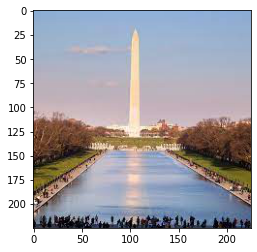

In [36]:

import urllib.request
url="data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFRgUFRUYGBgYGBgYGBgZGBoaGhoYGRgZHBgYGRocIS4lHB4tIRgaJjomKy8xNTU1GiQ7QDs0Py40NTEBDAwMEA8QHhISHjQrJSs0NTQ0NDQ0NDQ0NDQ0NDQ0NDQ0NTQ0NDQ0NDQ0NjQ0NDQ0NDQ0NDE2NDQ0NDQ0NDQ0NP/AABEIAOEA4QMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAAAAQIDBAUGB//EAEYQAAICAAQDBAYGCAQFBAMAAAECABEDEiExBAVBIlFhcRMygZGhsQZScsHR8BQzQmKCkrLhFSOi8TRTc8LSg5Oz4hZDVP/EABkBAQADAQEAAAAAAAAAAAAAAAABAgMEBf/EACoRAAICAQQBAwMEAwAAAAAAAAABAhESAyExQVETMmEEIoEUIzPhQnGR/9oADAMBAAIRAxEAPwDvyUKjqd9nHQo4VHUWKFCOoVFihQkqhUmxRGOOoVFihQjqOosURhHUKixQoR1CosUKKSqFRYojCOoVFihRVJRSbFBI1JRVIsUEVSUUmxQqikoqkWKIwkqjixRKEdRzOy1ChHHUWKFCOEWKFHCOosUKKSqFRZJGOOo6k2CMt4jBKEA9QD+PxkuGw8zqPH5C/umvmaaA9xr3/wC05562Oqo+TWOnlpuXg5tQqSqFTosxojCOoVFihVFUlUKixRGoVJVFUWKI1FJVCosURikqhUWKIwjIhUWKFCEIsUTjhC5Sy1BCO4rixRICPIZEMY/SGVbl0aRjHseWAQ90ExK31h6WRlLwSox8khhGRZCIHFboZFXbqYTkHGJKoRZjCzLWymMTXy5DnB8G/pM180HYH2h8mmXlfr79DNnNB2P4h8jOLUv11fwdMa9J0ciEIVO6zkoUZihFk0guK46iqLAXC4VCpNkUKEdRVFigMUdQqLFCijqFRYoUIVCLFE6hUUlM7NcQqFQjixiLLFlkoRYoWWGWShFkURywqShJsUKoVHHFijVyodv+E/dNvNfU/iH3zLyods/ZPzE1czHY/iE4dT+Zfg6Ir9pnGqFSUJ3Wc9CqFRwixQoR1CosiiMI6hUWKIwkqhUWKIyMnUKixRCElUKixRGElUIsUOOEJlZvQQhCLIxCFQhFjEKhUJINFhRFUKiZpJSOsZE4iqFSRIkbjIhxo38p9c/Z+8TTzL1PaJm5Vu3kPnNHMfUPmJyTf7y/BtGP2M5NQqK4TrswxHUIrhJsYjqEUIsYhCEIsYihCEWMQhCEWMRQhCLGIoQhFjElCSqFShpRGOOoRYoUI6jqSKIxSVQqBRGEllhUEURhJVCosmjdyoav/D980cwHYPmPnKeVD1/4fvl3HjsHzHznHL+b/htH2HIhCE7DChwihFihwihAocUIQKCKOK4snEIQhFighCFRZFChCoRZNF4EeWYuECoApcmhZ03Ph0O56zRhcSpYrmF+HTQaX1Oo98zs0otyxZZn4/FrKFYA2b1rQA3vM+Djv2QCKazZ33ND5RkMTo5YZY0a9OtWRLMkmypVUREtywyyQVVFUtywywCqoql2WRqLBu5Uth/Z98t5ilIfMfMRcqFK3mPlLeY+ofZ/UJzySzv5RdP7Th1CpPLDLOkoVwlmWGWAVwqWZYZYBVUKluWGWAVVCpYVhQ7xAK6hUg3F4YNFxcuWjsbqRaFEKhUtyxMANyIBXUIvTp9dP5l/GEWhR4jiOb4mILZiTsN6FVrQ8z8Zm4PjsRCSrb+e99PHx8JkxnAUDWxmbw1oAfD4mBJCitM4DGrqgxA89tvKcdvk6nR1eN5o7hcx7QFEgetvv3bn3yOHzV0qjVAgad/95zAxPsIrzOw89DDEatas3S9wG9xk7Gxv/wAbxB2WJYXsfKdXh/pAU7KEL3irF+R2nnEe91s+8+JFeEi9sQRpV+Hvk3vY6o+hcq5yHVc5Ft+146HtAaKNaE7GFiK4tGDDvBufLsDicvcQOn7JP3zscPztlACoq0N1CrZqr06y61Wij00+z3hWIL3T5xicwdjbOwPQX8vbO1ynnHFqhZCrjchgC1DrV2dzLer8FfSfR68cOxFhTK8h3qcdPpLxNU2FhEk2GsVW9UG3vxnR4L6SOWRWw6ViQzKwpdLFACz/ALyFqlXCR2OX4ZCnxN/dJcwXsH2fMTV6ZW1169D0P95Tx3FDDRnotkF0NyaurlX7rIV8HEKyIZe8bgbjrtpMH/5NxLNbYKZQTajNdBhYzXV1Q23NzPxvPeIZ7RHRQB2avzJuh0P4SZazXRaOm3yWc0w8VFLnECBiFCqWsUGI3A7jfsnSwcVHAKuvaJAtlBJBI2JvcTyXOec4jP2lN16hOl5asa+Z9sinFYuACScmdT3EMCSM3nr3Sq1Jcs1enFxpcnsMwzZetX4VdbyWWeO5fxqo6uRZHWhZsEZu7rNPH/SMLmCLWY7sxOvgL018peOvfKKS0UuGeoKzicZzinyKoI2a99SBsPP4jvnk+J5q7Kc7Enpq1jfxnPTimzZiTptve+358oepa2Cglyeh4vmLVX1TVHN0IKkg9ZqTiygVgCRs3UC/7Ubnl8+Ymyeg8rv74HGrRa0NGtPG7HzlM5F8Uetw0XO4rOhfU0eyCqEXWwBdTr1U9ZYvOcpOVRmZmZszUoUA+euk8tw3McRLIJCteZWZtbqyNf3V93hK34oMOyoWgNa+Nx6kiFGLPW8254qqig9vslwBoDV0pJ1mI80wHL2cQaCgSDZsWOlabdLE8nxXEs5BLX42fvlOJxBoUNB1A/Oki5Psn7V0er9Pw313/kP/AJRzyWY9x98cm35I2LOIB7QTVSQF6nsiidehu66ay7jEykKDogCA7A0KLe02fbK8uoO2hOu21iu/oPZIYWKw1O/7J3o9/dfnKEluK2WkvtAUb+t18q29nslLuAx1BoCzrvRlWETuQxrdqNE30PfrWvdFxKoKKgk2oarIrcgC/ACz/eWqmVbLGx7pb0O/w0MvJPjtqN+4D5zj4PFWzUBpYs6nyPQ+6WDmJ6jQb9oa+ypZwfRCmuzczkECxvtew03+c6PBEE9rbw0+P4904+Bjo5FkKe9thZ06Du2Anr/ovwiMpJbBfNhucrEWHvDy7jvz669e+VlF0FJGdeDWq1I79et9ffp+7JYGAMpyZjVdohrU662CB37z3J5bhtnUqn7eg3AY0Ks6UVbL3TO/KcJsQIno/XV3VGGYYZTShuAzLWmlknwmVS8izzpxHICsimtuy4I1GvreHxjw8ZQSvoiTuO0/Z8RVHod7G80834FcBkX0gdn6UBVns9Td9r+XxEvTlqZbzO3dkRdV1OYEmq2qz16StTJL+C+kWJhKVXDFE3qWJ2A6+AEnxH0ofFXIcFSrV+0RsQRrp3TD/hLlyFDVehYVp0sUalXE8tdGAHbFE9kjTbe68PYw9kZTRDiUpxKD/wDSSAQdWO+bN3fDykcHEwlu8Aspy9k4jgAL0BAvu3M24XLhQLuw2sKmeiWUAGmGva+EoxuEKvlzjKHClxVAGjnZb0GvvBHSSnMMx8U2EzFzgnYkoHajQOt1Y9kxjHV6Bwcg65XJ6akZvV9x2nsl+jpAosr9tLUZlGQls16jvB0N6Gt5kXkqk16K3CoSBjGwwxaLFQ1jsmj0oWNZZZ1uTGVHmeMdMNLOZiRsaHedxe1j3TzmLil21Ne34z6RzrkKsq3hClz65zQX0iVdEWQhY6763rPmvMUKEv2QNCEzElczYmmuugQD2r3zbSi/yRKaLmezQ8L118/GRfE6Hr3an3eyYl47s2V9o79dPnLnxUq9F8SdpZxaCkmamxaBvYdddul9R+e6Lh8S9DQvY9TvXs0Pv2nNweIUN616EULryN/naWDihRPT5bGqrWQ4hSOi+MtfnWZ/TBuyD7r69DUy8Vi9mlsn5d8fLyKIPfd/d3yMdrGVuiWKr5QO492x30gcwG/Tv/NdJP8ASOgqvZ7/ABlbDNYJINWDoPLX892skM0+kHefeITJ+iYvd8V/CEjbyLZoxMcNZevrEnskj9ld8unf0HkBIrxCkjM+p3y5q7pzyFZWZjrrlA0AJzAE+Ox06GN8RMiqi9qu01jU7keG8vijN6hfjYpZyEYlgDqCe4k6kaaXKMXHNBWN7nU30Ol771JJwrubPZ0om9wFCj1Qeg+M6PC8gvff94EX+A9kiU4R5K23wee1YBa28Kq6/ATQvCuQAbroBrPYYXLEWh8tvaOs1NwyBTaLQ1Ogmcvq1xFDB9nleB4ByRSmu4qDY9pGk7uHgphqGdMMd2RWzE9yqCbPlNfDjOcuCigA6uRSCquu8+O2hnY4HkeTOzFi7plD0pdTRzjDbcakeAyA7SLlPnb47LxjRk4XlLuVzIyKr5tWGoIJBoE0c1bbA14T0vB8vyEmrJok0BqAutHb1QfdNvD4NAXv8vxPjLco7p1aWko+4pOd7RMeKpO6/EdNpWmK66KzAdwevlNz4Y+qPcJUeHX6o/lE6ljXCOd5XyXcPiv9Y/zQd2X1SBdHfqAAD7gPdLcDhhWij+URY+DQ1Qe4TkajkdabxOY2O42I3vfrYN7d4HulBVvqrtWy7A2BttZv2zTiIPqysoO6dcIRrhHHOUr5J4OK49bPr1U6e6pyuP5O5t8N2QsAGpioOoJdiO1mtV1J311M6JwvD4xph5dV08jE9GMuNiYa0o/J5fjOLx8Mhcd8SmDEtnsfvhhvtV0NZwOa8ErreGhYk3nAzDXcWBPpONwqPlelJW9D0sUcteroSNq1Ok4XEcgwyxbCZsN9SQtCzZJLLRBGu4E8+ejKDtf0dKamtj5s/LWHePJT+EzvgstnRt9fZXXee44x8iqHXUEq5VNQfWBK7gZdfCUpwmG62GLA92Xr00Gkq9aUfcirg09jxGGwB0JGvXu/IqbuFxXbVVDkA0CL6UTXt99Tt8TyYAEi/aoM89igo3Zta7v7TSOpGfBW3Hkm2LS5Nc1a9KHdr5+2pLgsWiVuhQPmdL1mLExXJJJuwBr3D/aWtxnadigBbLouigAUwA8dPKppjsWU9zqYiHssqggXeuo7iPj8JLD4UuVIBDK2lXRsXR9x08CQJzW4+qKnUkDurxOmolvC82OUhrGwJGutqRpv+z0mTjJcGinFnov0TF/5be7+0U5Ppk70/n/+sJnjI0yQ+C5IGTMSN61zbb9+/hU6eDy9U9XJ/Lfv1uGFy2t8n+r7qluHhOmwA/hv3WdZhPUcuzFRrofo8ceqyEfZoeVTdhZqGcgHw1HymU8VkFuygU1WKJK3Yrrsdu6V/pWLiDMFdcIUz5fXdFC5qF6HMWWvyKrTlPxXklGnF41Qci2z6DKALF7FvqijZJ6DrOhwXKXch8Y1RBCL6oPjYttCBrsb7hM/0ew1YBsFO0LdlOlhs6ANZzAWnT96dziuaKlItF9m0tUPUHoW8Nh17j0R0UnSW/k02ju2T4rBRMI4RGfMhUJ2QStUL0pV6DTpoDOpwKndjZoC6qh3AdBORwT3qdybJ6nzncwFnbDTUUc0tRyZouQfFrvjyxZB3TRUU3KWxvOCm+pl/ox3RhB3SzfgJeR4b11aGI19T8Zv4bh1K6qIuI4ZANF+c5cllR0U8ThYuH4n3mUnC/e+P950Xwl7pX6Ne6dcXSOSStmA4PjD0fjN3ol7vjD0a90vkVowhSNQZB3v1t+hGhB7wQZvbCTulD4Kd0m0+URuuDmFMMMXdFLEUcQL2tq7QWj7Vrpp1mFuQIqh0Jd6AzKfXAYb60fVrW50+Kw6Gg908/i8RjYT2hNH1lYZkb7QHzFHxnHraK5R1aWq3tLcwHinXMuIMwXUuFI7OUt2lP7uSyOryGLwOC92gBF2NVYbbjT8ibnGDxOdf1eKWoKVBF0g/wAt3IXtBF0NE9AaN1cTwIVXZmxMNi4LIVNkYYpWXEa91z2NrYTklpeNv9GrinZwuJ5G19hVr7RMzryZuo91ffc7X6S6C2plOWnWqtwSPA7bjvmsYiNsR06ixY6jeZynqR5KOFcnm35BewI9o+78JQ3JsVCCozAG6seA079NJ6sKp2P5Bo/GPLUovqZoYo8R+h4//L+Ec9vp3fKEt+rl4IxE+OBYFWBeum+3xExcTzFnZUwULkozaDYoTRo76gb9xlfBcJjY+V3XIA5GSmU6C1oEakEEa/W23mt+J9BiJh4eGxTCRVzI/r/pGKCHZtQxFFQpJFk9Lkw0Ix53Zpuy3huRBR6THvEZnVDsVGYhCfWo6s9139K19Dy3Dw8XDTFZAnZzHMQMgPaNkGgOvkZLHC4bM+MCcLIi5nKlSQSSow6vNoCKBvwqcl+NbHoKoTD9ZUFWTd5sQDQt1rYeJFzeMWy0nGPBJuLRWKcMhRLUM+ozjMSVwxfYXfXQ66UBZhwfCnTQfGdLhuG02+U2YXDHunTGCRzymyXAYVCdfDMx4OCZqVDNaMrLC8gcTxkSJEiWSQtg2MYLjGRKwRIdUQm7NuFxRA6xYvGEx4eD5xY2DOb7cjq+7ExYvEmUniTLcTB0lBwfCdcKo45XYHipE8VA4XgZH0MvsVtiPFGVvxJ7jJnDkHw/H5/fJVFW2VPjHuMzYjnumhsLxErbB8R+fbLbFbZzsbARrBUa7yrieERwodPSoLGUuyuoP1WHrDT1WBGgoidBuHlJwqlJacJGsdSSNHL+XYRUKjM2ULmDkZ+zoudaoiwdRpd0Zz+efR9ERuIFoE7KuKVFZgBVCunlV+yWOCCCCQy6hgSCPIw4gnFSuIxMQITWdMuS7B/zMML5doa9KAucOp9O4vJPY6oaykqa3ObwHBYzB3UI+HhBrbMFb95tT9okHUWI8LGU5VzKWJYkX2lWmINDfYD2zrvydEQlC7o9eqEZGUajYWVNUcuuuk5nGfR8DBV8yo6hGZjdZgQXB7VDMQu2go9DOSenGRs0+kP2fn3QmX/A+L//AKE/mf8A8YTD0CKfg9DzjF4jgcRR2cfh+IBwrCKxfsFmZAHJBJzDoDrp1kOcPwyBXx1IxHyBMPOQxKtaXlNKATq3SyBd0YcbiouKVwabEw0JboEFqWLteZyTl7AI726XzsHl6u5d8zsWVizGySuo8APAUB0AneoJ8FXNxW5Xxau7guRQByouiIL2Qd56sdT7hOpy7hqO24EsbAGbadDhkAm8YUzGU7NfD4dLt8poRdpWjaSXpJpRlZoUyeaZfSQ9JJoWabimN8U9GPwlTYj/AFz/ACiSokZG8rJ4YnJOK/1/9A/GXJxLfW/0yJRdExkrO4mG1aNKsQN1Nznrxb9Gv3iU4vG4nenvP4TnUJWdDmqNjL4mZiPGY243FvZfefwlT8U91Q986YRZzSkjefOKz3znfpT9R8fujHEt1++a4szyN1nv+Mi0xjiY/wBJuKIsuYSphItjSDYnlFEWNhKnWM4kgXjcmyh085VinsZfG5e5lLyGrLp0ZOHx3wbbDYizbIRmRu/Mtij4ijpvNGLx6cWpwNMN2yjKWIawwN4b7Pt6vZarlTrMHFcErggj2ic89C3aOiGvWx2f8MP5wcT/AM45wv0V/wDn4v8A7mJ+Mcy/TyNPXid/HxcIdrDRUAQqcvUWDv1Og16zDyvmiPjHCAohVNkiiSLK+yx7Q21a+c5NzQfozIQ2anVCoBoV2bs9D8AJh5ZzM4OM2JRYqhJ0AOdUpA3QC9636TSKUaMZNys95j85QYeJir2hhPkb7QZQ2w/euQxPpVwyIjsxBdVZUy29EsOmmhRhv3dCDPGcq5kDweLgsCS7lswAsWUZtzqezp5mcrjCxZkVyVVQBYCZgGFaWeraa9JZyZCimtz6YPpJhvjpw+GSxZyrNRyjKCaX63qkaChd3U2PzjCCYr5tMFij6gHMAKUWepNC6198+QjiHw3Z0ZmcgjOazViKQ5AsmyGIzXY8Dts4/nOM+EmGzZUygMqgDPlIKsRVA9kbdRfWRkxij6lx/NcLCV2ZtMMIXrWg7ZVqtzsfIjvlXA83R8NcRz6MO5RFdgGzBitEH9qwTXdU+b4XN3dcZTk/zlGd2GUKUJxDVb5lTIBpdL1nU4jmqYw4UZVHoX9NiZACpLMrEBe81Zs6Gwb0JupMriqPc8v4sYyl1sUzL023X/SVPmTLzht3n3CePwfpIuA2Fh4aPkfFZ39XMQy9pVBseuxbceqBsZPlv0+VnVcTDKhi9ldaJb/LA1FitCe/WXzrZlXDwd/l3GDHDlCew7YZta7SnceHWX8Rjrh5Szhc7qi31dtAPnPP8NzfBwsLiBhZ87viulgaO6itToKI7jOGnEFHXDxmL/o+bFw7Gj4hcMS4O6lmfX46yHJ0EqZ9FxWyZQzgF2CILJLMegGvmT03leO5XFXBzDO6M4AqsqFQb63bCtNcrd0+e8F9I8R+K4Z+JY+jwgWKrdWFJLkE9okga30oVU3cz51h8RxWHxOEXUDh8UEFRaOUxFUAi+rXevqzDKWRvUaPQ835kOHwjisQ24QA+s1+rfTW9fOU4vO8O07a06Bwb2U1lzLuLv4GeGwnNojsxR2opZK5Qwz5RfUVrodPbI8YcM4ilcqo5UkICAoJpt0GXYnaaxm6ujOUI3sz6FxvFDDw2xGIygb2K3oAHz0mXged4eKoKtVsEGbTtlC1b9wO9aqRPP4nMeHHDLgo59GxZSHOYqFzOGyAE0zZda0voRpl5XgYS46BznDMznPZZmUEAEXRHaZtR08amjnVcFFp8nrsfmKri4eBds4LAdAgDENda3lIoeJ7ru4XiVxVLIbAYqfBlJBH57557iOOQ8bhOVCpghlLZa0ZCU0UXQzADoL85nbj04fGw1RuxeO7izqWDZCTveULp08Izpsrgdt+c4a45wGan7IBPqksLC30Oo0m83PGYHGricbh47KEVlDMaJpvQ5QBpZAIA23986A5+2GvEMzZv8wjBB10Oi33KKB36nrJjqeRKFcHoTcrbFUMFsZiCQt60DV13azjfRrjgMNmxMQFmxHbwF1t4XZ9s5HO+akcYjI+ihVYjUUxthXXRveO8Q5pKyFBt0esbiVz5M3aC5j5Gx9xiweJV1DIwKnrYPnPDcfznF9IScpJBXY6oTYU0RfXzkOB52+HhNhAfs6NrYLMAT7iKruEr6qfHBf0mj3WawCDYNEHoQdqlbH/AGnBSxwRAcAlC2jCwLzFdT3aUJj5rzLFDoNFIwwcwAJzPWaqutRVa7eUnOlbQwVtJnqbhOT/AIk31PnCPUQwZzOC9RfbFw/65/4P+6EJizUjwXqCY8f9aPIfOOEdBFbeuf8Ap/fLOP8A1Y+x/wByxwkIPkycR+pHmn9Ly7kPrN9kf1QhHaHR1Mb9dg+b/wBM4vK/1mH7f+6KEmXJCPRzI/69v+m//wAhhCXfRUz4frr/ANN/6zDlXqL9k/1YkISv+Rbokm+F9l/kJzH9ZvJf6IQggoHrnzb756E/8RgeTf0mEJm+jTyaOI/WH7K/0iczF/4nD8vvaEJeftZSPuNPD+t/C39cs4v1H8vvEcJMeCJcsOD9RZh4j/iU+2v9CQhEvaFyZeO3P2V/qWUp+39gfdCEyhwaS5Oq36pvsv8ANpTxvrn/ANP+swhN3wzJcl0IQlST/9k="

urllib.request.urlretrieve(url, "was.jpg")
suggest_locations('/content/was.jpg')

Is this is a picture of the

Stockholm City Hall, Whitby Abbey, Forth Bridge ?


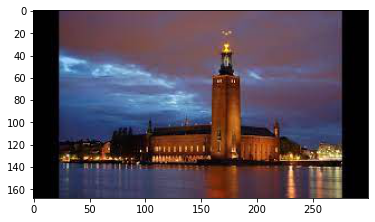

In [37]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
import urllib.request

url ="data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVEhgVEhYVGBIYEhISERIYGRgVEhIRGBgaGRgUGBgcIS4lHB4rIRgYJjgmKy8xNTU1GiQ7QDszPy40NTEBDAwMEA8QHxISHzQrJCs0NDQ0NDQxNDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIAKgBLAMBIgACEQEDEQH/xAAbAAABBQEBAAAAAAAAAAAAAAAAAQIDBQYEB//EAEEQAAIBAgQCBgcGBQQABwAAAAECAAMRBBIhMQVBEyIyUWFxBjNygZGhsRQjQnOywVJiwtHwBxWC4TRDY5Ki0vH/xAAaAQADAQEBAQAAAAAAAAAAAAAAAQIDBAUG/8QALhEAAgIBAwIGAQMEAwAAAAAAAAECEQMSITEEQRMiMlFhcZEFFIFEocHhIyQ0/9oADAMBAAIRAxEAPwDxmEIQAmwnrF9tfqJsBMfhPWJ7a/UTYCUpUa41Y8R4jRHCGo1oUGPEYI8R7C3HCPEYI8QtDHCKIgiiLYBRHCII4QSQWFosIRuSRKTYsIRbTNyNFESFo4CForHQ20LR1oWglYmxtooEIGaxgZykLGkxDCXdE8iGNtHQitMdNDcsS0feBjpCtjLQtHRJSJZGyxMskvGFoUmK2UfpSPul/MH6TMrNV6Un7pPbH6TMrMp8ksIQhIEEIQgBNhPWL7a/UTYCY/C+sX21+omwETRtiY9Y8RgjxFZsOEcI0R4hYJDhHCNEUGFjocI4RoiiTqCh4jhGCOEakDQ6LEEWPkV0LCJFvCgsWF4l4S1FE2xZ0IiEXLEWAzKRq5vqEsLDTvnMJ24bhtWopZEZkW+ZgNFsLzPJKMVbdFRTZyVcuY5L5b9W9s1vG0bFYRJrGe1Gco7iRIsI7DSJEixDFYUEIkbeNWDFMaTAmNIlogC0YxjjGGNCKT0n9Wvtj9JmYmn9J/Vr+Z/SZmJlLkmXIQhCSSEIQgB0YEXqoP8A1E+om6fD2mK4Pb7TRvt01K/lmF57nQ4bh6i337+RE6sEFJOzHLlcGqPPDTihJusR6N0j2HAPIG0qa3ACL2dDblfWVLAuxUerXczoSPCGdr4Ug7RFoHumfgGyz2tjlywyzt+zHujWoRSwDWc5QIokppmNKGYvFRssliCOiRZOhIepi3heAhHwHIt4QixOwCLCKBBRbBySEJtrLHhfpFhEoVkau6u6KtlU2BBt/wArk2sOV5wBZBgOGU2Srn7TGuSdgAiM9mN9Bc390w6nBrjUm+b2GsqXA9MQj3amSUucpIINrkftHGQ4FMtNV7gR8CRJ7TohDbklzsbEjjGmXVCTsaTEikRJNjoSJFhaNNsHQ2Bi5YZZorIdDDGmSMsa0qiLKH0n9Wv5n9JmYmn9KPVr+YP0mZiZT5JbthCEJAghCEAOvhnr6f5tP9QntXCnGVld1FxoTsDPE+Heup/mJ+oT0pa5/wAM7Om4Zy9RFyaLTFpVJNmUgc1I+dpxozA63kaVj4/GSDEefynVqRzqEjrw9MudBr3fvO44YIwHVbYm2tpWYfHlDdb9x8pO3FmJuAB5j+xidD0yNC/R5LZUJ521K+M4XwCMNG9xErEx7k3uLnuW37yb7Vfe95LQ0pImbhLDsAEfKQ1eGs57IuBqAJKMax5se68emMfyk0WpSKHE4Nl/CfhOboe+a5cQxPWs3nYzixGBLksoFj3bCZyxp7m8c74ZnLQtL2pwxlHWXTvErzhddplLEzeOaLOMCKROp8LbxERsPE8b9i1kT7nKI9TJxh4HCNyEShKIOcXyRVKypTZ37KAlramYjD8YqKrorCzhla4BJDqUbccwZq1xDuXpIjsRnV8tlOTNkbXXTrAX31mfxOGpISnQjMGKPdmYqykg2INr3E559RFukmaLp5c2i79HamejbUsh62hsASctvcss1p3lTw3EthqVgjdE5V1zWZQzhlVgdCLik+n8ku8K2emj6dZFYe8Xm2GUZ7LkzyRlj54GnCnmNO/lI3o2lxhsXlGVlBXn3zjxlNCb020/hItadLhGuDGOWTdMr7CBQSTovG0Zk8Znp+DTV8iFRBad+cUJGsvdHXuhX7MCkaRFKmRkGDfwNL5BjInMeUMYySG2UlH3KH0o9Wv5n9JmYmn9KB92vtj9JmYmL5JlyEIQiJCEIQAnwPrU/MT9Qm+S8wOB9an5ifqE3q1J19OrTMcrqjoRpOj+E5FeTIZ1KJjqR1BvCAJkSvJVaOhahwdhHrimHj7oi253MnVEt2Tfzk0GpCJxG34RBseTyEcKCnkfgDD7KD3/AAioalEReIsOQkqcTYbARg4d/MffHf7dbdgfK8W4aoHanGLizgFYlfFpbqkeRGvxkC4RALsfn/1O3DcLpv2XNxrly3HxhQrjZUM95zOTymqbCLbLcW3uVsfjrOCrgqYBLNr4RPcuORIoc5iiuw5zorqv4ZymQ00bxkn2Mzd8zspN2L3sxW4LXINjtpsfCceJuSDrcte+5PjrO9FOvvnLiFPV15zw9VyPXryiM75MpLZbrpmJW65svVvyztbuzN3maTh1UijT8Kaj4C0pOiOW8s8F6tPZnT0svM6MOoj5VZYnEmRtWnMWiF53+Izk8NHSa0Y1SQF4wvJchqB0GpGmpIC8QvDUPSTdLENSQFohaFhpJjUjTVMiLRheF0Oit9J3vTX8z+kzMTRekJ+7X2/2Mzsxk7ZElTCEISSQhCEAJ8F6xPbT6ibhagmGwvbX21+omtR52dM9mYZldFkrjvj1Yd8rw8erzqs53EsUt4yQVAO+VmYwDN3wthpRbLWWTJXHfKcM3cfdHLXI5GFhRoKWItqDr4GxnQapbW+vzPymdTGgbiTLxEQ2JcWXDOx/F+8chbvlN/ucaOKmLYelmmRxzF295Bljg8WF2RB5lgfceUxJ4k52ZhJaXEX/AI2+MTimLS0ajE5iTqD7yR8ZydG1iDY/X6zgTHMe0b225yQ4oHn3jfu0hpFuhHwpGuXTznHUp9wnV0yjU3I7iTY/AxDil5i2nebfAkxSjsawyNGQB6nKQVxfL7U6PwiQsLuo/m/afNJ7n0tbFouH+7uLXj8MPu18v3ljSw/3e3KclJQEAvrr9TN/0565tfBz9c9ME/kYwjSJKxHfIywnrvGjzllZGRGGSFo0kSNBprZGY0mPMabQ0hrGXiRWkZMNIahSYl40mNJjSQm2VvpAfu19v9jM/L3jp+7X2/2Mophk5JCEISACEIQAlw/bX2l+s06NMvh+0vtL9ZpEM6cD2ZE0T5o9akhBgDOpSMnE6RUMOkPIyAGOBjsnSdC1j4SUVu+cLNKyrjywFri7cjqVkSyRjyCxtmhuv+GKVXl9ZmftTZXuTckAC+g1O0s6GIGUEkbAnW14LLGQ/Ca7ncxA5Gc2ExN0Bbe5vbbcyN8QCGCuubL1Rfc3At8DfXulXXxLLZbkEFzpbUHbY+cynmUZV8FxxutzQriBJ+ntbTcXHiNr/IzJfa25u3xgMWTzY+88t5L6n2RXg33NkmKJvqLAXPLS4H7xhxdlBDbjMb3uCSTbWZD7X7/feOeo97ZDobbE6zOXUStOv7lxwxpr/Bp6mKtu66i/aGngfGMpYxCwDOoBNi1wSB32vrMwUe3YbX+VjBKb3F1YdYbqRzg+pk12GsEU+GaIsco8o09tPak1Y5ULG2gbe52Un/qMdT0ied54v+z173r6NZhn6v8AxmeqOodhp2jpLqjWy6c7H3iw5e+YHjVuncnS7D6CX+nS0ZW/gy65asa+zRMwjS/jMktS2zW252tJVxD/AMb/APuJE9rxjzFA07PbfzkKVrlhrofiJW4HiGhWqTto/wCzf3lm1JFqKKdspw1BzYk9Zhre532kPJc4pd7NFFaG/aiQNeIwjxbuikidNHO5kBiSbIsLDlCg1kBWIaZnVYeELQ0oWtmf48lqa+3+xlFNL6SLamun4x+kzNTlyqpGsXaCEITIYQhCAElA2ZSdswv8ZcNj0AuCSe61vrKVN/eJ3KhPZUfKXHJpQ1HUd68QTXU7XAsfhH4fGZ2IVGIAv1VLHe1yBsNR8ZWUmyMdtiptY6+BHjCmb3vex38YPPIFBFjVxxSwdGD72ZSt1vowB17/AISanjFNs3VvtcqR8QTb37+4zgp0mN8vSEWAyhtwu1/AXnRgsDeqEdTe2cqCGYWBIDWvY6bHvi/dSirKjg1Ol3J8bWIpZgrZWuqtsuvPvtvra0oQ81npIE+zqf8AzOlC6WK9HkJ11vfN7rWmVQfDe3Lb+0zjmeVamVkxLHLShhMAIERyr5bHnruBHZCRNhiQdPESxwFBSASFN73uL+8xaOCSnWrJUdGCU8T0dRHvTeqgOQo34gSNBznX6LNQNS2I9Xax1K779nWY5Xs2jpxJWrJ6NBbdlR5KBHsluVvcJ19NQ6+UWAw9MrcnrVsyBrX30LG0kR6PS0gSuQ0s1QlrAVMraE36p0XScblK+DtSjRzUyfH5RXOnM/CKMTT+z3uOl6ci1+t0eRTe3dmvrOmtiqHS1coXo+ibo9bjpMgAIIOpzXI/wSXfsPY4XPf9f2ErncFhYnt28hpp8by0rYimcOlrdL0lXP8AxZMqZL+F8848ZWpfbDkyigaq2y9nLZb2995rC99jOb4LFqYZcpKi4sCyCotzp2SfnEyWqIDvax8wN4tA6qdWAdC2UXsoYFj7heceKxFqiHmJkk3t9l7J39Fji62Wqx0sLD/42lYXYksGYAnSzWHwltjqSHBGqHRqhFMlA6l1+8ZWuo1FhY++VODt0a+L2HjbNeOMaV/wFpuv5OvDqxsMzHQ6E3Gw3BnV9jUg5kQ66XpoTaw/l84zDlbubCwp9buvkF7y1VBdBzyE+4qmv1mU8klwbxhFrdFBi8Clj93T9yKv6bSmxTstgjFdAunJdSB5XvNLj3GRbHfNax3Fzt8pR8bpooplGzZqVN31vZzmDLpta206MGSdq2c3Uwgoukc+E4i6aOxYciTcj3y0pYsPsfMSkSmz3ygnZjYbDvklHRl9tbjW+4uPfPQh1Ljs9zzHgUuC6zeAkZaGASq69hCLscwzB9LdUg6W/wC504XBVHqpSFOoGqKHQFbFqdi2cXOosCbjunT+5hV2ZvDJdjmYEbhtdjY2I7wfdEDTWPwAIzKEGYMqkMAqK7EDV/8Ale5PI8heQ47gyPc01CXNNVDjKRmAUudWJXc5rkDTacq/UFe6NH067MwvpAfu19v+k/3mem19OODvh0VXKmzqCytmQkqxsD3ixExUrxPE8xLjp2CEIQEEIQgBLQtmW+2YX56X7p6PwDCYdFR1FN6nSKGSsUVGpmykGmW11Nwb+6ecYcddfaX6zbcJWl0idMisod2YFFa65CANRrrbT3yZ4XkVp1RcMig91ZDivsINVbt0nSuoK0wyKikglSG8PgdpWcHOGFa2KdxRCm7IvXLW0GU35/4JKcKlrZF3PIf2kmAwVMVLuilcr6Wza5TbQ6b2gulai92wWZWqRMy4Jmujsimp1A4XMKdjdnYE2a+XQAjfWWhHDadVGpVmIAAqMVPWY3zZQOQHeZV18DR6+VF1qAppayWbTTbddPCdOIwNA1KZWmoXo6YcWsCw7RsN/OZvpJPuzaPUJStJbCY2jw1ulYYllbtUAKbnM1ybP1RlGw0J5mca8MwVgxxQOaiTlClSle3YfMOzvqNTptynxHDqGV8qLclsvgL6W7oxOF0rP1B/4YZd7ir93cjXfRtfEyl08orZsmWRN8Iq6+ARQesxdajI4yEIi6ZGLE7t1rCw7Mhx+DVahSkWexYAlCrNYnXJrbbv01lpVwAamN8zVXZzma5AC5b3NjqX8dZYUAaVSsKbMFqZqbHM1zTL3sDfMNPG8pYpoTnFoylRBmITVbqAf5bAXM1nolwLD1aSviGYN9pamVDFSaaoSVt35iNb8pVV+DoGfLewvk10tfS1zfbvvH4LhSntX8yzdx/hIiyY5ONK0PHJKVuvyaWnwDDEK2ZicmF0D6uQSKpFu8BfKQPwGgQuRm1TctfrF9G00tl0085Wpw0AgqzAoAEs7jLe+bL1tL35SE8EW+hNsv8AE3anN4E75f4Orxo+y/Jbca4FTpUyUIaqHLZQ+dejKAqotpob6ysw+EpsGDZlIfow2Y26puzW/mW47tOUZU4SAikM18xB651Hl8ZHV4UoLAM9gOr1ybeG2vyjWNpU2/wLxN7SX5JsRVwlNgHFQ3AdbFrFWvZTqCLaeOnOcNDEYQK+cVC5pt0Ta2Wpa6uQD3gCx0teLW4SpCsWckkhrsGNuW40+c5zwtcxFzYXtt7tba/KWoxS5ZEpTk+ER0uLOvMwOOJYMbm0k/2te8/KInDQWtmP1hqxCrMXSeklAUFpnDXqDNmqlyAAxOmQL1hY8++VmF4iqoFa4KtcWBOa97+VtPjO1+Ap0RYM2cW5rl316tr/ADlZ/tw5n5SYLFJPT7lN5Yu2duB4squ5LHKytYa72AFvn8Jevx2jdOvfqa21sbKLeG0zCcLBPaMnPB006zbfy7yJ4ccnvZpDLmS2SOniXEOsoBuuQnKCrWJY7kHQ7SbA0aReoldqR+7UI+dAt89iylyuthexsbecq6nClFrFttb23vytyjavDUUixbYHW2/u5SljjVJkzyT3bRvOBPhaVVCow51a6mpTZTYZRrnIGlj5iNr8MwJSsWemHLs9FeloqpZswCtd+yBY8pT+hnA0r4pUZqgGRnuoRtQNiGUixnJWwqFn6Tpeq5CgZARYkWa4+gmP7d69pMNacdx+FpvTqKUr4YIDqGr0ipUa5TZr/CXNWtQNVHWtQVVqs+UYhCwp2sqqSxtrcnXUtMnS4erOAWYKWANlBYAnlcgEy4q+idI1QiVaozKGUtTRtLEm9nF9rct50SxJeoyU99j0Cpxfhyg3xSNmsws7LlIO1s1jOd/TDA6BqtI5MpVsuZyoN8uYProbTz5vRcB6iNWfqMqg9Dvc2uRn0+Jj63oT95TQV2IcqA3QkEX8M5vbzmaw41sRKT9ix/1J4zhK9Bfsxps5r9I5UEPlKMDc5jfW243nms1vpV6Otg6ZXpC6NWQH7s0wWCOQSCTtmIGvMzJTqxpKPl4MZchCEJZIQhCAEuG7a+0v1E1uHVidBrr9JksP219pfrNVQcja/ObY+GRIjJj6LG8iZo+i9jN+wlyT5vrJmc3HkOc5y/1vJGq3INhsIhj3YxyNv7PykTODHJUGvlaD4DuKG0HnHZtZGG0HnHB9YAkDNH0mkTNrHUmiYLk6Q/j9Y7pJEr+ckziSUI7yNmj3cW3jGI8JDRpFjG2kLILmSmRs/nObMvLsdWF77kTJG0949nkKHWcCOyVdi1LnoyOUrmE7h2OU4GM6elS3OfO3sPWSFpApkhM6JRRjGTEcyKqY5zGVDFFKxyflZrP9PqmXEMbEnoyLD/8AJUcab7+rvq7Hy15yz9AntWJAY9Xlb95w+kgtiH0YXNyDa95jF/8AYf0U1/wplVRfrjzE0mHxQ6ZDrotrTMUj1h5zRYd06RDpt3Tozcfwc+P1L7OzjGITpLqoFwt+VyOcmo4oGpSP8J7x/wDacPEHRqn4dvKdOHpIWTbQ95/vOTbSi8q8zKv/AFOrhkX84Hl/A3cTPN56L/qTSUU0K86o5k/hbvM86m+H0IwlyEIQmhIQhCAElDtr7Q+s0iP4mEJtj4ZLIy8lpPYxITQSJs8mLi42hCMAYiKlvlEhAAAEWwvCEY0NaKkIRMXcmUyT3whJKGtI2hCSy0R3j1MWE58/pOvp/UgZVtynMwAMITzVyelJeU6BUOWcjGEJ29OuTz84Ax+aEJvIxiMdpG5hCJcjlwzT+g9TLUNrEkdm37yL0qe9cnQeHdCE5V/6X9HR/TlBTbrDzmiw1TrLp/nwhCdOb0nJD1L7JcYy5tR9JPhil12+A1hCcq9KNMvqZV/6jgdClretG2/ZaedQhN8PpOaXIQhCaEn/2Q=="

urllib.request.urlretrieve(url, "image.jpg")
suggest_locations('/content/image.jpg')

